# Task - Differential Power Attack

This task will deal with subjects regarding AES and power analysis. 
It will help a lot to refresh your knowledge on them before you start with the task.
Check the following materials of the Hardware Security & Trust slides if you need help throughout this task:
- Chapter 02_2-crypto_AES contains the AES algorithm. 
- Chapter 03_02-Side-Channel-Attacks contains a lot of information about power analysis. Particulary an example of the differential power analysis on DES has quite a simillar setup as we use it.


## Attack Assumptions

### Microcontroller power and leakage

Modern microcontrollers face the challenge of reducing the peak power consumption as much as possible. If hypothetically the databus lines' states switch from 0 to 1 or vice versa all at once this would yield in the maximum power draw peak required for switching all the data lines' states.<br>
![precharge](images/precharge-combined.png)<br>

Let's say switching one data line from 0 to 1 or vice versa requires 10 energy units. For the 32 bit microcontroller, there are 32 data lines.<br>
This means that in the worst case scenario 320 energy units are required simultaneously per clock for switching the data lines' states.<br>

To reduce this required peak power draw, engineers came up with a trick of precharging the data lines. Instead of only switching the data lines' states once per clock cycle, they are switched twice, but only half way each time as shown in the image above.<br>

In the second half of the clock cycle all lines are brought to 0.5 so-called precharge state. At the clock, all lines are brought to their respective target level. This limits the maximum power draw peak to only half of the previous one.<br>
In terms of the energy units, since the data lines' states are never changed directly from 0 to 1 or vice versa the simultaneously required peak energy units are halfed. The data lines' states can be changed from 0 to 0.5, 0.5 to 1 or vice versa, each change requires only 5 energy units and therefore, with 32 data lines, the maximum power draw peak is limited to 180 energy units at once.<br>

This precharge, however, allows for straight forward leakage in the context of a side channel attack.<br>

The power consumption of the chip varies depending on the number of bits on the data lines and due to this precharge it varies with the number of bits in the output of the S-Box.<br>
Fortunately for this task, the STM32F3 implemented in the ChipWhisperer board uses precharging allowing to leak information.<br>
This effect can be used to leak information about the output value of the S-Box, which in turn allows to deduce information about the input value of the S-Box if for example the ciphertext is known.<br>

### AES and S-Box

This Attack will take place on the S-Box of the AES-Algorithm. To understand the attack we will look at the AES algorithm first.

The attack will target an AES-128-Encryption implementation, working on a high-level as follows: 
1. Key expansion - Generate 11 round keys $k_0, ... k_{10}$ from secret key $k$. 
2. Initial round key addition $A := P \oplus k_0$ with $P$ being the plain text
3. ```python
    for(i=1; i <= 10; i++){
        A := SubBytes(A);
        A := ShiftRows(A);
        if(i < 10) // not in last round
            A := MixColumns(A);
        A := A ^ k[i];
    }
    ```
4. Ciphertext is output of last round $C := A$

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Later in the task we will try to extract the round key $k_0$ from the power trace. Familiarize yourself with the key schedule of AES and give the relationship of the round key $k_0$ to the secret key $k$?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

The S-Box is a Lookup Table used in the AES-Algorithm.<br>
The Input of the S-Box is one byte, which is given by XOR'ing an input byte with a key byte.<br>
![aes-input-sbox](images/aesinput.png)
The S-Box is constant, independent from the key and has the following 256 entries:

In [1]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    [0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76], # 0
    [0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0], # 1
    [0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15], # 2
    [0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75], # 3
    [0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84], # 4
    [0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf], # 5
    [0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8], # 6
    [0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2], # 7
    [0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73], # 8
    [0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb], # 9
    [0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79], # a
    [0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08], # b
    [0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a], # c
    [0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e], # d
    [0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf], # e
    [0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16]  # f
]

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">With the information and S-Box table as provided above, how many bits are set for the input byte `0x3a` and key byte `0xc4` in the output of the S-Box?</font></span>
</div>

In [2]:
s = int('0x3a', 16) ^ int('0xc4', 16)
print(hex(s))

0xfe


<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

'0xfe' wir mit der S-Box zu '0xbb' umgewandelt. Steht auch für 187

## Recovering an AES key byte from a single bit. 

To get started with the key extraction you need to define a function that takes an input byte and a key byte and returns the output of the S-Box. 

In [3]:
def aes_sbox(inputdata, key):
    input_s = inputdata ^ key
    if input_s < 16:
        return sbox[0][input_s]
    row = input_s // 16
    col =  input_s - (16 * row)
    return sbox[row][col]

In [4]:
aes_sbox(0x3a, 0xc4)

187

You can verify the model works by running the following block.

In [5]:
#Simple test vectors - if you get the check-mark printed all OK.
assert(aes_sbox(0xAB, 0xEF) == 0x1B)
assert(aes_sbox(0x22, 0x01) == 0x26)
print("Implementation successful")

Implementation successful


In the next step we feed the AES algorithm with 1000 bytes of random input data.<br>
The AES processes the data and the output of the first S-Box is then observable on a data line with a probe.<br>
The measured data line is our exploitable leakage.

The following block will simulate this behavior and also add some noise on the data line.<br>
The secret key byte and the dataline value is hidden in the function and can not be extracted easily in practise.

In [6]:
import random

data_line = 3           # 'Secret' dataline the virtual probe is connected to

def aes_secret(inputdata):
    secret_key = 0xCD       # Secret key byte, which we want to find out
    
    correct = aes_sbox(secret_key, inputdata)

    if random.randint(0, 100) < 50:   # Add some noise
        return correct
    else:
        return random.randint(0,255)
    
input_data = [random.randint(0,255) for _ in range(0, 1000)] # Generate Input data for AES

leaked_data = [((aes_secret(a) & (1<<data_line))>>data_line) for a in input_data] # Simulated leakage measured by the probe


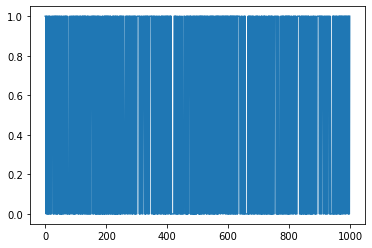

In [7]:
#You can print or plot your data here 
import matplotlib.pylab as plt
plt.plot(leaked_data)
plt.rcParams['figure.dpi'] = 300
plt.show()

The attack is straight forward. Let's just use our model of the device (we know what the encryption does after all, just not the secret key). And we'll feed in the observed data for each possible value of the key and then we can observe how many (if any) of the key guesses result in the observation and simulation matching each other. If the observation and simulation match, this suggets our simulation is running in the same "setup" as the implementation we are attacking, meaning they are using the same key byte!

First, build a function to count the number of elements in a list that match between two lists (that is - same value of the element at the same list index). An easy way is to just iterate through the number of elements in the list and count the number of times they are the same. Fill in the following - there is already some bounds checking code to get you started.

In [8]:
def get_list_similarity(a, b):
    
    if len(a) != len(b):
        raise ValueError("Arrays must be same length!")

    if max(a) != max(b):
        raise ValueError("Arrays max() should be the same!")
    
    #Count how many list items match up
    same = 0
    for x in range(len(a)):
        if a[x] == b[x]:
            same += 1

    return same

In [9]:
#Simple test vectors - if you get the check-mark printed all OK.
assert(get_list_similarity([0,1,0,1,1,1,1,0], [0,1,0,1,1,1,1,0]) == 8)
assert(get_list_similarity([4,4,4,4,0,0,0,0], [0,4,0,4,0,0,0,0]) == 6)
assert(get_list_similarity([8, 0], [0, 8]) == 0)
print("Implementation successful")

Implementation successful


We know that our probe captures the output of the S-Box but let's assume we do not know which data line we are actually probing as it will be the case in the next section of this task.<br>
Let's also create another helpful function, which is able to check if a bit in an output byte is set (` return 1`) or not (`return 0`). 

In [10]:
def get_bit(output, bit):
    try:
        return int(bin(output)[-(bit + 1)])
    except:
        return 0

In [11]:
bin(0x00)

'0b0'

In [12]:
assert(get_bit(0xAA, 7) == 1)
assert(get_bit(0xAA, 0) == 0)
assert(get_bit(0x00, 7) == 0)
print("Implementation successful")

Implementation successful


Last but not least we need a guessing function, which takes the unknown probing location into consideration.<br>
The output should reveal if a bit, at the output of the S-Box, is set. Use the function `get_bit(...)` from above.

In [13]:
def guess_leakage(keyguess, inputdata, bit):
    return get_bit(aes_sbox(keyguess, inputdata), bit)

In [14]:
assert(guess_leakage(0xAB, 0x22, 4) == 0)
assert(guess_leakage(0xAB, 0x22, 3) == 0)
assert(guess_leakage(0xAB, 0x22, 2) == 1)
assert(guess_leakage(0xAB, 0x22, 1) == 1)
assert(guess_leakage(0xAB, 0x22, 0) == 1)
print("Implementation successful")

Implementation successful


In the following section we will use `numpy.argsort` for sorting lists. `numpy.argsort` doesn't return a sorted list but a list of indexes that are put in order to match the original list as if it was sorted.<br>

Generate a `list_sorted_ascending` and `list_sorted_descending` from the `list_unsorted` provided below.<br>
Note: to reverse the order of a list, slicing can be used:

Example:
```python
a = [1, 2, 3, 4, 5]
b = a[::-1] # => b = [5, 4, 3, 2, 1]
```

In [15]:
import numpy as np
list_unsorted = [42, 13, 7, 9, 64, 3]
sorted_indexes = np.argsort(list_unsorted)
list_sorted_ascending = sorted_indexes
list_sorted_descending = sorted_indexes[::-1]

We can now set up our guessing loop with respect to the input data and our model.<br>
The idea is to simulate the theoretical leakage for a given key byte guess `guess` and bit `bit` for the used input data `input_data`.<br>

This can be done by iterating over every possible `bit`, computing the theoretical leakage `simulated_leakage` for every input byte from the `input_data` and scoring the similarity `similarity_score` between the `simulated_leakage` and the "measured" `leaked_data`<br>

To find the best key candidate the result can be sorted by the `similarity_score`.<br>

You can do this by sorting the list of (`leaked_data - simulated_leakage`) matches and print out the first few for every bit.<br> 

In [19]:
import numpy as np # use np.argsort(guess_list)[::-1] for sorting
restult = {}
restult.update({"Key-guess": [], "simmularity": [], "bit": []})
#guess_list = []
for g in range(2 ** 8):
    for n in range(8):
        simulated_leakage = []
        for d in input_data:
            simulated_leakage.append(guess_leakage(g, d, n))

        (restult["Key-guess"]).append(g)
        (restult["simmularity"]).append(get_list_similarity(leaked_data, simulated_leakage))
        (restult["bit"]).append(n)

In [28]:
key_guesse = restult["Key-guess"]
simmularitys = np.argsort(restult["simmularity"])[::-1]
score = restult["simmularity"]
bits = restult["bit"]
print(f"there have been {score[simmularitys[0]]} hits, at bit {bits[simmularitys[0]]} with key {hex(key_guesse[simmularitys[0]])}")

there have been 746 hits, at bit 3 with key 0xcd


<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What is your best guess for the key according to your results and why?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What is your best guess for the data line the probe was connected to according to your results and why?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Thus far, the S-Box computation following the first round key was attacked. Would it be possible to run this attack on another round key with similar success and why?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

## Guessing a key byte with differential power analysis on AES

You saw how a single bit of information can be used to recover an entire byte of the AES key. Remember, this works due to the S-Box being present in the data flow that we are attacking.

Next, we will see how to use differential power analysis instead of an actual bit value with this technique. Power traces are recorded, while the microcontroller is applying the AES algorithm. The goal is to separate the recorded power traces by a bit in the result of the S-Box output (it doesn't matter which one) into two sets: if that bit is 1, its group of traces should, on average, have higher power consumption during the S-Box operation than the other set.

If you have difficulties imagining how this works, check out the Hardware Security & Trust slides. DPA including helpful visualizations are introduced in chapter 3.2 slides 42 to 60: https://ilias.uni-freiburg.de/goto.php?target=file_1913465_download&client_id=unifreiburg

Remember that this is based on the assumption that there is some consistent relationship between the value of bits on the data bus and the power consumption in the device.

To get the attack working you first need to send random data to the device, and observe the power consumption during the encryption. 

We will use a capture loop like this:

```python
    print(scope)
    for i in trange(N, desc='Capturing traces'):
        key, text = ktp.next()  

        trace = cw.capture_trace(scope, target, text, key)
        if trace is None:
            continue
        traces.append(trace)
        plot.send(trace)

    #Convert traces to numpy arrays
    trace_array = np.asarray([trace.wave for trace in traces])
    textin_array = np.asarray([trace.textin for trace in traces])
    known_keys = np.asarray([trace.key for trace in traces])  # for fixed key, these keys are all the same
```

ChipWhisperer comes with some helper scripts to get started and to interface with the ChipWhisperer board.

For your convenience they are located in the subfolder `helper_scripts/`.

Please plug in the ChipWhisperer with the provided USB cable and run the next code cell.

The following Jupyter Notebook will initialize the Hardware and run the capture loop. 
Check it to get the hardware running.

Running the script `helper_scripts/Setup_Generic.ipynb` should result in the output:<br>
Serial baud rate = 38400<br>
INFO: Found ChipWhisperer😍

In [ ]:
# settings for generic setup
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

# run the setup script
%run "helper_scripts/Setup_Generic.ipynb"

Brilliant! The connection to the ChipWhisperer board is now established.<br>
A custom firmware for the target chip is required for this task.<br>

The next code cell flashes the provided `aes.hex` file to the target chip.
This flashes our victims firmware onto the device. The firmware is kept quite simple, it receives a text and applies a software implementation of the AES algorithm to the incoming text message.

In [ ]:
# flash the target firmware to the ChipWhisperer STM32 chip
target_firmware = "aes.hex"
cw.program_target(scope, prog, target_firmware)

A power side channel attack is based on recording and processing power traces. The following image shows the simplified set-up used to record the traces as implemented on the ChipWhisperer board.<br>
![precharge](images/side-channel-probing.png)<br>

The following code snipped allows convenient recording of the traces. The trace recording is triggered with every incoming serial message.<br>
The trigger is only active if the scope is armed by calling `scope.arm()`.<br>
For the sake of this task, the trigger is embedded into the source code of the victim's firmware and triggers every time just before the AES algorithm is applied to the received text message.

The following lines of code are executed for each incoming text message:

```C
aes_indep_enc_pretrigger(pt);  /* preparation for aes computations not interesting for DPA */

trigger_high();                /* set trigger -> begin capturing the trace */

aes_indep_enc(pt);             /* encrypting the data block */
trigger_low();                 /* Doesn't stop recording, trace recording runs for fixed number of samples */

aes_indep_enc_posttrigger(pt); /* cleanup of aes computations not interesting for DPA */
```

You will generate 150 (to start with) text messages, send them to the victim microcontroller and record a power trace for each ot them while the AES algorithm is being applied.<br>
Comparing the different power traces for different input data with each other and keeping the nature of the AES algorithm and the S-Box in mind, you should be able to extract the key bytes from the recorded power traces.

In [ ]:
##### # Perform the capture, resulting in trace_array and textin_array of 500 traces.
#

from tqdm import tnrange
import numpy as np
import time

# set up key text pattern (ktp) acquisition: Basic works just fine we only use the random text.
ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

_, text = ktp.next()

N = 250 # number of traces
for i in tnrange(N, desc='Capturing traces'):
    
    # Arm the ChipWhisperer with scope.arm(). 
    # It will begin capturing as soon as it is triggered (which in our case is a rising edge on gpio4).
    # The gpio4 is set high from the firmware as soon as it receives the message.
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    # scope.capture() will read back the captured power trace, blocking until either ChipWhisperer
    # is done recording, or the scope times out.
    # Note that the error return will tell you whether or not the scope timed out. 
    # It does not return the captured scope data.
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    # You can read back the captured power trace with scope.get_last_trace()
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    _, text = ktp.next() 


To get a grasp on the input and collected data, you can visualize them.

Let's first have a look at the input text stored in `textin_array`:<br>

In [ ]:
raise NotImplementedError("Add your code here, and delete this.")

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Is there any requirements for the input text data for the captured traces you can think of?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Are these requirements fulfilled by the generated text data in `textin_array` at first glance? (You don't have to do an in depth analysis here)</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

Let's have a look at the recorded traces next.

In [ ]:
# find the number of recorded traces and data points per trace from the trace_array

numtraces = #total number of traces
numpoints = #samples per trace

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">How many traces have been recorded and how many datapoints does each trace have?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

Plot a couple of traces using matplotlib.pylab from the `trace_array`.

For example you could plot the 5 most distinctive traces, to get a sensible idea about the data's conformity.
Because of the high number of samples per trace, the computation might take up to a few minutes.

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt
plt.figure() # Creates a new figure

# get the 5 most distinct traces and plot them in a single plot
raise NotImplementedError("Add your code here, and delete this.")

<div>
<img src="images/hint_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">If you chose a different visualization, please describe your approach in a few words:</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What are your observations, do they meet your expectations?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

The attack needs a way of splitting traces into two groups, depending on the state of a bit in our "guessed" value. We're going to start by guessing a single byte of the AES key at a time.

Think about a suitable approach and come up with an implementation for separating the traces in a meaningful way to do a statistical analysis on them.<br>

This is not particularly easy so here are some hints for when you get stuck.

<font color="darkgreen">
<details>
<summary>
<div>
<img src="images/hint_darkgreen.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em">
<b>Click to show hints</b>
</span>
</div>
</summary>

This is a brute force like attack, where every combination is tried and the results are put into bins to get a significance.
    
You need to iterate over the `keybyte guess` and over each `input byte` and therefore `trace`.<br>

The theoretical leakage hypothesis must be computed using the S-Box, while focusing on a single bit and the trace must be put into the according bin, either `ones` or `zeros`.

The sorting must now be analysed. If the traces were sorted randomly, the average of the traces in the `ones` bin should not be very different from the traces in the `zeros` bin.
    
This changes if the theoretical leakage matches with the actual leakage, the average of the traces would have a significant difference, since the sorting correlates with the actual leakage.
    
To get the average of your `one_list` and `zero_list` you can use numpy:

```python
    import numpy as np
    avg_one_list = np.asarray(one_list).mean(axis=0)
```    

The important thing here is the `axis=0`, which does an average so the resulting array is done across all traces (not just the average value of one trace, but the average of each point index *across all traces*).

</details></font>

<font color="darkgreen">
<details>
<summary>
<div>
<img src="images/hint_darkgreen.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em">
<b>Click to show more hints</b>
</span>
</div>
</summary>

To guess a single byte of the key, you can use the algorithm given by the following pseudo code:

```python
    for each key_byte_guess_value:

        for each trace_index:
        
            input_byte = textin_array[trace_index][byte_to_attack]
            
            #Get a simulated leakage list - use aes_sbox(guess, input_byte)          

            if simulated_leakage of Bit 0 is 1:
                append trace_array[trace_index] to one_list
            else:
                append trace_array[trace_index] to zero_list
                
        one_avg = average of one_list
        zero_avg = average of zero_list

        max_diff_value = maximum of ABS(one_avg - zero_avg)
```

Imagine the Secret Key Byte would be `0x34`, the loop would generate `max_diff_value`'s like this:

    Guessing 31: 0.001432
    Guessing 32: 0.000876
    Guessing 33: 0.001239
    Guessing 34: 0.004891
    Guessing 35: 0.000862
    Guessing 36: 0.003193
    Guessing 37: 0.001742
    Guessing 38: 0.001662

Note the value of `0.004891` for `0x34` - this is higher than the others, which range from `0.000862` to `0.003193`.<br>
Try to guess the first key byte yourself. (byte_to_attack = 0)

</details></font>

In [ ]:
import numpy as np
mean_diffs = []
byte_to_attack = 0
bit_to_check = 0
data_line = 1<<bit_to_check

raise NotImplementedError("Add your code here, and delete this.")

# Print your possible Keybyte canditates 
get_highest = np.argsort(mean_diffs)[::-1]
for guess in range(0, 5):
    print("Possible Candidate: " + hex(get_highest[guess]) + " with significance " + str(mean_diffs[get_highest[guess]]))

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What is the best key byte candidate according to your result and do you trust the significance?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

Check the leakage on a different data line by changing `bit_to_check`. 
Depending on your traces you might get different results or very close significance.

In [ ]:
import numpy as np
mean_diffs = []
byte_to_attack = 0
bit_to_check = 0 # Try a different bit
data_line = 1<<bit_to_check 


raise NotImplementedError("Add your code here, and delete this.")

# Print your possible Keybyte canditates 
get_highest = np.argsort(mean_diffs)[::-1]
for guess in range(0, 5):
    print("Possible Candidate: " + hex(get_highest[guess]) + " with significance " + str(mean_diffs[get_highest[guess]]))
print("")


<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What is the best key byte candidate according to your result now and do you trust it any better?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

<font color="darkgreen">
<details>
<summary>
<div>
<img src="images/hint_darkgreen.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em">
<b>Click to show hints</b>
</span>
</div>
</summary>

Remember, the key is fixed. Gained insight from this analysis adds to the previously gained information but doesn't replace it.

</details></font>

Let's implement a naive approach to solve for the key byte.<br> 
We repeat the previous code but introduce another loop, which goes trough all the possible bit values of the simulated leakage.
Adding up the different `max_diff_value`'s for every bit might give us a more definite result.

To make things more clear, first implement the `calculate_diffs` function.

In [ ]:
# In guess = Byte guess
# In byte_to_attack = Byteindex
# In bit_to_check = bit position in the leakage
# Out return = list with abs(one_averages - zero_averages) 
"""
Loops through all the traces and take the `bit_to_check` into consideration
"""
def calculate_diffs(guess, byte_to_attack=0, bit_to_check=0):
    """Perform a simple DPA on two traces, uses global `textin_array` and `trace_array` """
    
    raise NotImplementedError("Add your code here, and delete this.")
    
    return 
    

Given the previous function, it will be straight forward to implement the naive approach.<br>
Since this function might run for a while, use
```python
for guess in tnrange(0, 256, desc="Attacking Keybyte"):
```
for your outer loop to keep track of what your function is doing and how long it will be running.

In [ ]:
#raise NotImplementedError("Add Your Code Here")

# start Solution
mean_diffs = [0] * 256
byte_to_attack = 0

for guess in tnrange(0,256, desc="Attacking Keybyte"):
    raise NotImplementedError("Add your code here, and delete this.")


# Print your possible Keybyte canditates 
get_highest = np.argsort(mean_diffs)[::-1]
for guess in range(0, 10):
    print("Possible Candidate: " + hex(get_highest[guess]) + " with significance " + str(mean_diffs[get_highest[guess]]))
        
# end Solution

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Every bit has been checked regarding the simulated leakage. What is your best guess for the key byte?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What do you gain from the results and can you trust your best guess more than before and why?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

The result is probably more clear for you now but the algorithm takes quite some time.
There might be a more elegant solution compared to our naive method.
To see that solution we should first find out what causes different bytes to have such a high significance.  

## Locating Error Sources in the power traces

So far we were using the max value of our list of differences. Is this always a good idea?<br>
It might be helpful to analyze the list of differences itself.<br>
Plot some of them. Good candiates are your observed key byte and (if you found some) close candidates.
You can analyze the list of differences of the observed key byte on different data lines to get a better understanding of what is happening in the trace.

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt
plt.figure()

raise NotImplementedError("Add your code here, and delete this.")

If you did your analyzing, try to answer these questions:

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">What is considered the max value in every plot?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Is there a difference where this max value is located?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Can you use this knowledge to your advantage?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

## Retrieving the full key

You were probably waiting the whole time for this.<br>
So far you retrieved a single key byte, which, in the first step, might even have been the wrong one.<br>
After that you learned a naive approach on how to solve that problem.<br>
In the last section you might have guessed another approach on how to retrieve all key bytes.

In this section you have full freedom on how to get the key.<br>
You can try it in every way but the actual probability to retrieve the key successfully might differ between the methods.

In the very last section you can check your retreived key by decrypting a short text message. 
Good luck!

In [ ]:
raise NotImplementedError("Add your code here, and delete this.")

<font color="darkgreen">
<details>
<summary>
<div>
<img src="images/hint_darkgreen.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em">
<b>Click to show hints</b>
</span>
</div>
</summary>

You may change the different steps including the initial setup and trace recording, processing and analysis. You may replace the naive approach by a more sophisticated one and add filters to enhance the significance of the resulting key bytes.

</details></font>

## Test your key


As mentioned before we give you a chance to test your key.<br>
Decrypt the following text.

In [ ]:
from Crypto.Cipher import AES

msg = b'g\xf4\x9b\xf2\xe7[\xf5)g2V\xcau\x89\xfe\xa1'
raise NotImplementedError("Add your code here, and delete this.")
#key = bytearray()
#decipher = AES.new(key, AES.MODE_ECB)
#print(decipher.decrypt(msg))


## Conclusion

Just by observing the power lines of a microcontroller executing an AES encryption you were able to deduce the key used for the encryption.

But why was this possible?

### Exploited weaknesses

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">List the weaknesses you have exploited throughout this task and explain why they lead to you deducing the key bytes.</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

### Promising counter measures

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">Can you think of one or more promising counter measure(s) that would have prevented your attack from being successful?</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>

### Challenges

<div>
<img src="images/question_darkblue.png" align="left" width="24" height="24"/>
    
<span style="line-height:24px; margin-left: 0.5em"><font color="darkblue">List the challanges you faced and describe your train of thought that lead you to mastering them.</font></span>
</div>

<div>
<img src="images/write_chocolate.png" align="left" width="24" height="24"/>
<span style="line-height:24px; margin-left: 0.5em"><font color='Chocolate'>
<b> Please fill in with your own observations </b>
</font></span>
</div>

<font color='Chocolate'>
replace this line with your observations
</font>




## Submission

Please commit your changes thus far until the end of the timeframe of this task according to:<br>
https://gitlab.tf.uni-freiburg.de/embex-security-lab/security-lab-2022

## Additional presentation task

**You only have to work on the following task if you decided to present for this task**<br>
You are welcome to continue working on the following task without presentation, if you have chosen a different task to present.

There are a number of different ways to retreive the key. In section 1.5 you implemented one such way. Can you think of optimizations for the analysis of the power traces or other ways to perfom such a differential power analysis attack?<br>

You have full freedom and are welcome to also modify the capturing function and initial data sent to the victim.

Discuss your approaches and results. Did the results follow your initial intuition?<br>
Which approach lead you to the highest level of certainty about the retrieved key?<br>
Is there a combination of methods you would choose?<br>

Create a presentation with a few slides showing your approach and results from this task.

You can find the date for the presentation here: https://gitlab.tf.uni-freiburg.de/embex-security-lab/security-lab-2022

*Acknowledgement: the material used in this task is inspired and partially taken from the ChipWhisperer learning material.*